# Required Imports

In [ ]:
! pip install datasets

In [3]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from string import punctuation

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

Загружаем FastText эмбеддинги для английского:


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec

In [6]:
!tail -n 2 wiki.en.vec

# Описание задачи

Классификация твиттов по тональности
<br>
Классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

# 1. Создание матрицы эмбеддингов

Функция для представления эмбеддингов из *vec файла в формате матрицы с индексами токенов

In [7]:
def load_embeddings(path, num_tokens=100_000):
    """ Представление эмбеддингов в формате матрицы """

    token2index = dict()
    embeddings_matrix = list()

    with open(path) as file_object:
      vocab_size, embedding_dim = file_object.readline().strip().split()

      vocab_size = int(vocab_size)
      embedding_dim = int(embedding_dim)

      num_tokens = vocab_size if num_tokens <= 0 else num_tokens

      token2index['PAD'] = 0
      embeddings_matrix.append(np.zeros(embedding_dim))

      token2index['UNK'] = 1
      embeddings_matrix.append(np.ones(embedding_dim))

      for line in tqdm(file_object, total=num_tokens, desc='Loading Embeddings'):
          parts = line.strip().split()
          token = ' '.join(parts[:-embedding_dim]).lower()
          if token in token2index:
              continue
          word_vector = np.array(list(map(float, parts[-embedding_dim:])))
          token2index[token] = len(token2index)
          embeddings_matrix.append(word_vector)
          if len(token2index) == num_tokens:
              break

    embeddings_matrix: np.array = np.array(embeddings_matrix)
    
    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

Создаем словарь с индексами токенов и матрицу эмбеддингов

In [8]:
token2index, embeddings_matrix = load_embeddings('wiki.en.vec')

Loading Embeddings:   0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
token2index['hello'] # индекс для токена 'hello'

4857

## 2. Загрузка данных для обучени, приведение в подходящий для Torch формат

Загрузка датасета tweet_eval/sentiment с помощью функции load_dataset:

In [ ]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

In [11]:
tokenizer = ToktokTokenizer()

Средняя длина текстов в тренировочном сете:

In [ ]:
lengths = [len(tokenizer.tokenize(t['text'])) for t in tqdm(train_dataset)]

In [13]:
np.percentile(lengths, 97) # 97% текстов не больше 34 токенов

34.0

Класс Tokenizer для представления текстов твиттов в формате тензоров с индеками токенов

In [14]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, max_length=32):
        
        self._base_tokenizer = base_tokenizer
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = 'PAD'
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = 'UNK'
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):

        tokens = self._base_tokenizer.tokenize(text)
        return tokens
    
    def indexing(self, tokenized_text):
        """
        Tokens to indexes
        """
        indexed_text = [token2index[t] if t in token2index else self.unk_index 
                        for t in tokenized_text]
        return indexed_text
        
    def padding(self, tokens_indices):
        """
        Adding pad tokens
        """
        if len(tokens_indices) > self.max_length:
          tokens_indices = tokens_indices[:self.max_length]
        elif len(tokens_indices) < self.max_length:
          padding_size = self.max_length - len(tokens_indices)
          tokens_indices.extend([self.pad_index] * padding_size)

        return tokens_indices
    
    def __call__(self, text):
        return self.padding(self.indexing(self.tokenize(text)))
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            tokenized_texts.append(self(sample['text']))
            labels.append(sample['label'])
            
        tokenized_texts = torch.LongTensor(tokenized_texts)
        labels = torch.LongTensor(labels)
        
        return tokenized_texts, labels

In [33]:
tokenizer = Tokenizer(
              base_tokenizer=ToktokTokenizer(),
              token2index=token2index,
              max_length=34
)

In [34]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)

In [35]:
for x, y in train_loader:
    break

Проверка

In [36]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# 4. Выбор метрики 

Метрика Accuracy не подойдет для данной задачи, т.к. классы несбалансированы:

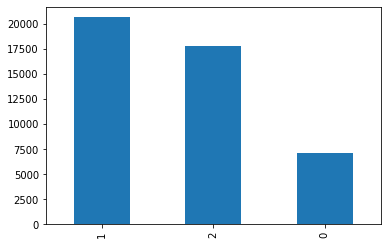

In [37]:
df = pd.DataFrame.from_records(train_dataset)
df['label'].value_counts().plot(kind="bar")
plt.show()

Для данной задачи я выбрала метрику **macro-F1-score**. Эта метрика хорошо подходит для задач классификации с дисбалансом классов, где нам важно равносильно учитывать качество всех представленных классов. 

# 5. Реализация модели Deep Average Network



In [51]:
class DeepAverageNetwork(nn.Module):
    """
    Deep Average Network Class
    """
    def __init__(self, embeddings_maxtrix, in_features=300, inner_features=300, out_features = 3):
        
        super().__init__()

        self.embedding_layer = nn.Embedding(len(embeddings_maxtrix), 
                               embeddings_maxtrix.shape[-1]).from_pretrained(embeddings_maxtrix, freeze=False)
        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features, inner_features)
        #self.batch_norm = nn.BatchNorm1d(inner_features)
        self.relu = nn.ReLU()
        
        # self.dropout2 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(inner_features, out_features)
        self.batch_norm2 = nn.BatchNorm1d(out_features)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.embedding_layer(x)
        # рандомно отбрасываем эмбеддинги для 30% токенов перед усреднением
        # если я правильно поняла, в статье про DAN использовался такой подход
        x = self.dropout1(x) 
        x = torch.mean(x, dim=1).float() # усредняем эмбеддинги
        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout2(x)
        x = self.linear2(x)
        x = self.softmax(self.batch_norm2(x))
        
        return x

In [52]:
model = DeepAverageNetwork(embeddings_maxtrix=torch.Tensor(embeddings_matrix))

In [53]:
model = model.to(device)

In [54]:
criterion = torch.nn.CrossEntropyLoss().to(device)

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 6. Обучение

In [56]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.
valid_preds_final = {'preds': [], 'targets': []}

for n_epoch in range(epochs):
    
    train_losses = [] # train losses for current epoch
    test_losses = [] # test losses for current epoch
    test_preds = [] # predictions to evaluate the model on current epoch
    test_targets = [] 
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        optimizer.zero_grad()
        
        pred = model(x.to(device))
        
        loss = criterion(pred, y.to(device))
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in valid_loader:

        with torch.no_grad():
            
            pred = model(x.to(device))
            
        test_preds.append(pred.to('cpu').numpy()) # batch predictions
        test_targets.append(y.to('cpu').numpy())

        loss = criterion(pred, y.to(device)) # batch loss

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, validation = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds = test_preds.argmax(1).tolist() 

    valid_preds_final['preds'] = test_preds
    valid_preds_final['targets'] = test_targets

    f_score = f1_score(test_targets, test_preds, average='macro')

    print('Validation: macro f1 - {:.3f}'.format(f_score))
        
    # early stopping
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    

Epoch 1:   0%|          | 0/45615 [00:00<?, ?it/s]

Losses: train - 0.959, validation = 0.923
Validation: macro f1 - 0.560


Epoch 2:   0%|          | 0/45615 [00:00<?, ?it/s]

Losses: train - 0.873, validation = 0.913
Validation: macro f1 - 0.577


Epoch 3:   0%|          | 0/45615 [00:00<?, ?it/s]

Losses: train - 0.834, validation = 0.912
Validation: macro f1 - 0.583


Epoch 4:   0%|          | 0/45615 [00:00<?, ?it/s]

Losses: train - 0.809, validation = 0.921
Validation: macro f1 - 0.580
Early stopping


# 7. Анализ качества модели

На Classification report видно, что хуже всего модель распознает класс '0' (негативные твитты). В обучающем датасете для этого класса было меньше всего примеров. Нейтральные и позитивные твитты модель распознает с более лучшим качеством, однако в целом качество модели нельзя назвать удовлетворительным.

In [57]:
print(classification_report(valid_preds_final['targets'], valid_preds_final['preds']))

              precision    recall  f1-score   support

           0       0.51      0.40      0.45       312
           1       0.59      0.68      0.64       869
           2       0.68      0.63      0.65       819

    accuracy                           0.62      2000
   macro avg       0.59      0.57      0.58      2000
weighted avg       0.62      0.62      0.61      2000



Матрица ошибок:

[Text(42.0, 0.5, 'TRUE'), Text(0.5, 42.0, 'PREDICTED')]

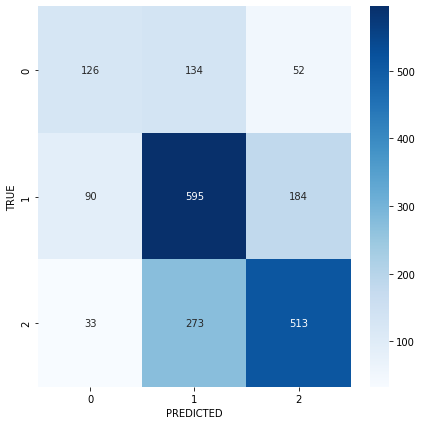

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(7,7))  

cf_matrix = confusion_matrix(valid_preds_final['targets'], valid_preds_final['preds'])
classes = [0, 1, 2]

s = sns.heatmap(cf_matrix, annot=True, ax=ax, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
s.set(xlabel='PREDICTED', ylabel='TRUE')

Оценим качество модели на тестовой выборке

In [59]:
def get_preds(loader, model):
  test_preds = []
  test_targets = []
  for x, y in loader:
        with torch.no_grad():
            pred = model(x.to(device))
        test_preds.append(pred.to('cpu').numpy()) # batch predictions
        test_targets.append(y.to('cpu').numpy())
                
  test_preds = np.concatenate(test_preds)
  test_preds = test_preds.squeeze()
  test_targets = np.concatenate(test_targets).squeeze()
  
  test_preds = test_preds.argmax(1).tolist() 

  return {'preds': test_preds, 'targets': test_targets}

In [60]:
test_predictions = get_preds(test_loader, model) # предсказания модели на тестовой выборке

Видим, что качество на тестовой выборке хуже, чем на валидации (что ожидаемо):

In [61]:
print(classification_report(test_predictions['targets'], test_predictions['preds']))

              precision    recall  f1-score   support

           0       0.67      0.35      0.46      3972
           1       0.60      0.65      0.62      5937
           2       0.39      0.62      0.48      2375

    accuracy                           0.55     12284
   macro avg       0.55      0.54      0.52     12284
weighted avg       0.58      0.55      0.54     12284



# Выводы

Я поняла основную идею Deep Average Network, однако построить качественную модель пока не вышло. В данной задаче присутствует дисбаланс классов, и в целом различать несколько тональностей сложнее, чем в бинарной классификации (где только positive/negative). Но как минимум в качестве бейзлайна полученная модель вполне может подойти. 

Как можно попробовать улучшить модель:
<br>
— реализовать residual connection для линейного слоя (пока не разобралась, как это делается)
<br>
— попробовать взять эмбеддинги от transformer-модели, например, из модели [Twitter-roBERTa-base](https://huggingface.co/cardiffnlp/twitter-roberta-base) (roBERTa, дообученная на твиттах
<br>
— возможно как-то поменять слои в модели (пробовала добавить еще один скрытый слой с ReLU, но это не особо помогло)